# Preprocessing Demonstration


This notebook demonstrates the **preprocessing utilities** shipped in `ThreeWToolkit.preprocessing`. Functions demonstrated:
- `impute_missing_data`
- `normalize`
- `windowing`
- `rename_columns`

Importing libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ThreeWToolkit.core.base_preprocessing import (
    ImputeMissingConfig,
    NormalizeConfig,
    WindowingConfig,
    RenameColumnsConfig,
)
from ThreeWToolkit.preprocessing import (
    ImputeMissing,
    Normalize,
    Windowing,
    RenameColumns,
)
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig
from ThreeWToolkit.dataset import ParquetDataset
from pathlib import Path

Loading 3W Dataset:

In [2]:
# define path
dataset_path = Path("./data/3w_dataset/")

# create and load
ds_config = ParquetDatasetConfig(path=dataset_path, clean_data=False, download=True)
ds = ParquetDataset(ds_config)
len(ds)

[ParquetDataset] Dataset found at data/3w_dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


2228

Preparing dataset for demonstration:

In [3]:
ds_config = ParquetDatasetConfig(path=dataset_path)
raw_dataset = ParquetDataset(ds_config)

# Select a single event from the dataset
event_id = 0
event = raw_dataset[event_id]

# Convert the 'signal' to a pandas DataFrame
signal = pd.DataFrame(event["signal"])

# Convert Period columns to datetime for compatibility
for col in signal.columns:
    if isinstance(signal[col].dtype, pd.PeriodDtype):
        signal[col] = signal[col].dt.to_timestamp()

[ParquetDataset] Dataset found at data/3w_dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


## Impute Missing Data

Function to fill missing values in DataFrames or Series using different imputation strategies

The function accepts:  
- A Pandas **DataFrame** or **Series** (`data`) containing missing values to impute  
- An imputation strategy (`strategy`) which can be:  
  - `"mean"` → replaces NaNs with the column mean  
  - `"median"` → replaces NaNs with the column median  
  - `"constant"` → replaces NaNs with a constant value provided by the user  
- A constant value (`fill_value`, optional) required if the strategy is `"constant"`  
- A list of columns (`columns`, optional) to apply the imputation; if not provided, all numeric columns are imputed  


### Basic Usage using mock data

Using `"mean"` value:

In [7]:
df = pd.DataFrame({
    "a": [1.0, np.nan, 3.0],
    "b": [np.nan, 2.0, 2.0],
    "c": ["x", "y", "z"]
})

impute_missing = ImputeMissing(
    ImputeMissingConfig(strategy="mean", columns=["a", "b"])
)

df_pre = impute_missing.pre_process(df)
df_imputed = impute_missing.run(df_pre)
imputed_df = impute_missing.post_process(df_imputed)

imputed_df.head(5)

,a,b,c
0,1.0,2.0,x
1,2.0,2.0,y
2,3.0,2.0,z


Using `"median"` value:

In [8]:
df = pd.DataFrame({
    "a": [1.0, np.nan, 3.0],
    "b": [np.nan, 2.0, 4.0],
    "c": ["x", "y", "z"]
})

impute_missing = ImputeMissing(
    ImputeMissingConfig(strategy="median", columns=["a", "b"])
)

df_pre = impute_missing.pre_process(df)
df_imputed = impute_missing.run(df_pre)
imputed_df = impute_missing.post_process(df_imputed)

imputed_df.head(5)

,a,b,c
0,1.0,3.0,x
1,2.0,2.0,y
2,3.0,4.0,z


Using `"constant"` value:

In [9]:
df = pd.DataFrame({
    "a": [1.0, np.nan, 3.0],
    "b": [np.nan, 2.0, 4.0],
    "c": ["x", "y", "z"]
})

impute_missing = ImputeMissing(
    ImputeMissingConfig(strategy="constant", columns=["a", "b"], fill_value=-1.0)
)

df_pre = impute_missing.pre_process(df)
df_imputed = impute_missing.run(df_pre)
imputed_df = impute_missing.post_process(df_imputed)

imputed_df.head(5)

,a,b,c
0,1.0,-1.0,x
1,-1.0,2.0,y
2,3.0,4.0,z


### Using 3W data as example

Using column "T-TPT" to demonstrate this functionality. First, overriding 5 values with `NaN`:

In [10]:
col = "T-TPT"
indices_to_nan = signal.index[:5]

# Introduce NaN
signal.loc[indices_to_nan, col] = pd.NA

print("\nValues after introducing NaN:")
print(signal.loc[indices_to_nan, col])



Values after introducing NaN:
timestamp
2018-09-05 20:44:36   NaN
2018-09-05 20:44:37   NaN
2018-09-05 20:44:38   NaN
2018-09-05 20:44:39   NaN
2018-09-05 20:44:40   NaN
Name: T-TPT, dtype: float64


Applying `"mean"` imputation:

In [11]:
impute_missing = ImputeMissing(
    ImputeMissingConfig(strategy="mean")
)

signal_pre = impute_missing.pre_process(signal)
signal_imputed = impute_missing.run(signal_pre)
signal = impute_missing.post_process(signal_imputed)

print("\nValues after mean imputation:")
print(signal.loc[indices_to_nan, col])


Values after mean imputation:
timestamp
2018-09-05 20:44:36    0.492552
2018-09-05 20:44:37    0.492552
2018-09-05 20:44:38    0.492552
2018-09-05 20:44:39    0.492552
2018-09-05 20:44:40    0.492552
Name: T-TPT, dtype: float64


________

## Normalize

Function to normalize input data using **L1**, **L2**, or **max** norm

The function accepts:  
- A Pandas **DataFrame** or **Series** (`X`) containing the data to normalize  
- A norm type (`norm`) which can be:  
  - `"l1"` → normalization using the L1 norm (sum of absolute values = 1)  
  - `"l2"` → normalization using the L2 norm (Euclidean length = 1)  
  - `"max"` → normalization by dividing by the maximum absolute value  
- An axis (`axis`, default = 1):  
  - `0` → normalize along columns  
  - `1` → normalize along rows  
- A flag (`copy_values`, default = True) to indicate whether the normalization is performed on a copy of the input  
- A flag (`return_norm_values`, default = False) to return both the normalized data and the computed norm values  

### Basic Usage using mock data

Using L2 norm with a DataFrame:

In [12]:
df = pd.DataFrame({"x": [3, 4], "y": [0, 0]})

normalize_step = Normalize(NormalizeConfig(norm="l2", axis=1))

df_pre = normalize_step.pre_process(df)
normed_array = normalize_step.run(df_pre)
normed = normalize_step.post_process(normed_array)

normed

,x,y
0,1.0,0.0
1,1.0,0.0


Using L2 norm with Series (Pandas)

In [13]:
s = pd.Series([3.0, 4.0], name="s")

normalize_step = Normalize(NormalizeConfig(norm="l2", axis=0))

s_pre = normalize_step.pre_process(s)
normed_array = normalize_step.run(s_pre)
normed = normalize_step.post_process(normed_array)

normed

0    0.6
1    0.8
Name: s, dtype: float64

### Using 3W data as example

Using column "T-TPT" to demonstrate this functionality.

Checking column before normalization:

In [14]:
col = "T-TPT"
signal[col].head(10)

timestamp
2018-09-05 20:44:36    0.492552
2018-09-05 20:44:37    0.492552
2018-09-05 20:44:38    0.492552
2018-09-05 20:44:39    0.492552
2018-09-05 20:44:40    0.492552
2018-09-05 20:44:41    0.589097
2018-09-05 20:44:42    0.589097
2018-09-05 20:44:43    0.589097
2018-09-05 20:44:44    0.589097
2018-09-05 20:44:45    0.589097
Name: T-TPT, dtype: float64

Applying L2 normalization and checking results:

In [15]:
# Apply L2 normalization row-wise
normalize_step = Normalize(NormalizeConfig(norm="l2", axis=0))

signal_pre = normalize_step.pre_process(signal[col])
normed_array = normalize_step.run(signal_pre)
signal[col] = normalize_step.post_process(normed_array)

signal[col].head(10)


timestamp
2018-09-05 20:44:36    0.001414
2018-09-05 20:44:37    0.001414
2018-09-05 20:44:38    0.001414
2018-09-05 20:44:39    0.001414
2018-09-05 20:44:40    0.001414
2018-09-05 20:44:41    0.001691
2018-09-05 20:44:42    0.001691
2018-09-05 20:44:43    0.001691
2018-09-05 20:44:44    0.001691
2018-09-05 20:44:45    0.001691
Name: T-TPT, dtype: float64

________

## Windowing

Function to segment a 1D time-series into overlapping windows and apply a specified windowing function  

The function accepts:  
- A Pandas **Series** (`X`) representing the input 1D signal  
- A window function (`window`, default = `"hann"`):  
  - A string for standard windows (e.g., `"hann"`, `"hamming"`)  
  - A tuple for parametrized windows (e.g., `("kaiser", beta)`)  
- A window size (`window_size`, default = 4): number of samples per window  
- An overlap ratio (`overlap`, default = 0.0): must be in the range `[0, 1)`  
- A flag (`normalize`, default = False) to normalize the window function to unit area  
- A flag (`fftbins`, default = True) to generate FFT-compatible windows  
- A flag (`pad_last_window`, default = False) to pad the last incomplete window with constant values  
- A padding value (`pad_value`, default = 0.0) used when `pad_last_window=True`  

### Basic Usage using mock data


In [16]:
# Simple time series
serie = pd.Series(np.arange(12), name="sinal")

# Applying windowing without overlap
windowing_step_no_overlap = Windowing(WindowingConfig(window="boxcar", window_size=4, overlap=0.0))
serie_pre_no_overlap = windowing_step_no_overlap.pre_process(serie)
result_no_overlap = windowing_step_no_overlap.run(serie_pre_no_overlap)
result_no_overlap = windowing_step_no_overlap.post_process(result_no_overlap)

# Applying windowing with 50% overlap
windowing_step_overlap = Windowing(WindowingConfig(window="boxcar", window_size=4, overlap=0.5))
serie_pre_overlap = windowing_step_overlap.pre_process(serie)
result_overlap = windowing_step_overlap.run(serie_pre_overlap)
result_overlap = windowing_step_overlap.post_process(result_overlap)

print("Without Overlap:\n", result_no_overlap)
print("\nWith 50% Overlap:\n", result_overlap)

Without Overlap:
    var1_t0  var1_t1  var1_t2  var1_t3  win
0      0.0      1.0      2.0      3.0    1
1      4.0      5.0      6.0      7.0    2
2      8.0      9.0     10.0     11.0    3

With 50% Overlap:
    var1_t0  var1_t1  var1_t2  var1_t3  win
0      0.0      1.0      2.0      3.0    1
1      2.0      3.0      4.0      5.0    2
2      4.0      5.0      6.0      7.0    3
3      6.0      7.0      8.0      9.0    4
4      8.0      9.0     10.0     11.0    5


Example with 0.5 of overlap + visualization:

   var1_t0   var1_t1   var1_t2   var1_t3   var1_t4   var1_t5   var1_t6  \
0      0.0  0.030491  0.209083  0.541729  0.871539  0.998533  0.840267   
1      0.0  0.088709  0.263321  0.337434  0.194443 -0.108119 -0.379793   
2     -0.0 -0.040096 -0.237594 -0.578266 -0.892593 -0.986827 -0.799144   
3     -0.0 -0.084368 -0.237594 -0.274821 -0.097795  0.214970  0.466323   
4      0.0  0.049231  0.263321  0.608023  0.903182  0.963550  0.748652   

    var1_t7   var1_t8       var1_t9  win  
0  0.498842  0.178119  2.052785e-02    1  
1 -0.450105 -0.305246 -9.423355e-02    2  
2 -0.450105 -0.145068 -1.032445e-02    3  
3  0.498842  0.320954  9.535146e-02    4  
4  0.396092  0.110316  3.508301e-17    5  


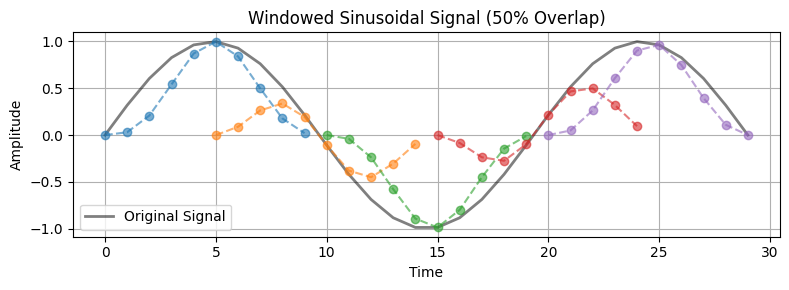

In [18]:
def plot_windowed_series(original, windowed_df, window_size, title="Windowed Signal"):
    fig, ax = plt.subplots(figsize=(8, 3))

    # Plot original series
    ax.plot(original.index, original.values, label="Original Signal", color='black', lw=2, alpha=0.5)

    # Plot each window segment
    for _, row in windowed_df.iterrows():
        window = row.iloc[:-1].values
        idx_start = int((row["win"] - 1) * (window_size * (1 - overlap)))
        idxs = np.arange(idx_start, idx_start + window_size)
        ax.plot(idxs, window, linestyle='--', marker='o', alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Parameters
window_size = 10
overlap = 0.5

# Series and windowing
windowing_step = Windowing(WindowingConfig(window="hann", window_size=10, overlap=0.5))

serie = pd.Series(np.sin(np.linspace(0, 3 * np.pi, 30)), name="signal")
serie_pre = windowing_step.pre_process(serie)
result = windowing_step.run(serie_pre)
result = windowing_step.post_process(result)

# Values to check
print(result)
# Plotting
plot_windowed_series(serie, result, window_size, title="Windowed Sinusoidal Signal (50% Overlap)")

Example with padding:

In [19]:
serie_pad = pd.Series(np.arange(13), name="signal")

# Without padding
windowing_step_no_pad = Windowing(WindowingConfig(window="boxcar", window_size=5, overlap=0.3, pad_last_window=False))
serie_pre_no_pad = windowing_step_no_pad.pre_process(serie_pad)
res_no_pad = windowing_step_no_pad.run(serie_pre_no_pad)
res_no_pad = windowing_step_no_pad.post_process(res_no_pad)

# With padding
windowing_step_pad = Windowing(WindowingConfig(window="boxcar", window_size=5, overlap=0.3, pad_last_window=True, pad_value=-1))
serie_pre_pad = windowing_step_pad.pre_process(serie_pad)
res_pad = windowing_step_pad.run(serie_pre_pad)
res_pad = windowing_step_pad.post_process(res_pad)

print("Without Padding:\n", res_no_pad.tail())
print("\nWith Padding:\n", res_pad.tail())

Without Padding:
    var1_t0  var1_t1  var1_t2  var1_t3  var1_t4  win
0      0.0      1.0      2.0      3.0      4.0    1
1      3.0      4.0      5.0      6.0      7.0    2
2      6.0      7.0      8.0      9.0     10.0    3

With Padding:
    var1_t0  var1_t1  var1_t2  var1_t3  var1_t4  win
0      0.0      1.0      2.0      3.0      4.0    1
1      3.0      4.0      5.0      6.0      7.0    2
2      6.0      7.0      8.0      9.0     10.0    3
3      9.0     10.0     11.0     12.0     -1.0    4
4     12.0     -1.0     -1.0     -1.0     -1.0    5


Example with tuple like for parametrized windows:

In [20]:
# Simple time series
serie = pd.Series(np.arange(12), name="sinal")

windowing_step_tukey = Windowing(WindowingConfig(window=("tukey", 0.25), window_size=3))
serie_pre_tukey = windowing_step_tukey.pre_process(serie)
wind_tukey = windowing_step_tukey.run(serie_pre_tukey)
wind_tukey = windowing_step_tukey.post_process(wind_tukey)

windowing_step_kaiser = Windowing(WindowingConfig(window=("kaiser", 4.0), window_size=3))
serie_pre_kaiser = windowing_step_kaiser.pre_process(serie)
wind_kaiser = windowing_step_kaiser.run(serie_pre_kaiser)
wind_kaiser = windowing_step_kaiser.post_process(wind_kaiser)

windowing_step_cosine = Windowing(WindowingConfig(window=("general_cosine", [0.5, 0.5]), window_size=3))
serie_pre_cosine = windowing_step_cosine.pre_process(serie)
wind_cosine = windowing_step_cosine.run(serie_pre_cosine)
wind_cosine = windowing_step_cosine.post_process(wind_cosine)

print("Tukey shape dataframe:\n", wind_tukey.shape)
print("Kaiser shape dataframe:\n", wind_kaiser.shape)
print("General cosine shape dataframe:\n", wind_cosine.shape)

Tukey shape dataframe:
 (4, 4)
Kaiser shape dataframe:
 (4, 4)
General cosine shape dataframe:
 (4, 4)


### Using 3W data as example

The column "P-TPT" will be used to demonstrate this functionality.

Checking column before windowing:

In [18]:
col = "P-TPT"
signal[col].head(10)

timestamp
2018-09-05 20:44:36   -2.374172
2018-09-05 20:44:37   -2.374172
2018-09-05 20:44:38   -2.374172
2018-09-05 20:44:39   -2.374172
2018-09-05 20:44:40   -2.374172
2018-09-05 20:44:41   -2.374172
2018-09-05 20:44:42   -2.374172
2018-09-05 20:44:43   -2.374172
2018-09-05 20:44:44   -2.374172
2018-09-05 20:44:45   -2.374172
Name: P-TPT, dtype: float64

Applying windowing (Hann window, window size 4, 50% overlap, and pad the last window) and checking results:


In [ ]:
windowing_step = Windowing(WindowingConfig(window="hann", window_size=4, overlap=0.5, pad_last_window=True))

signal_pre = windowing_step.pre_process(signal[col])
windowed_df = windowing_step.run(signal_pre)
windowed_df = windowing_step.post_process(windowed_df)

print("\nAfter windowing (first 5 windows):")
display(windowed_df.head())


After windowing (first 5 windows):


,var1_t0,var1_t1,var1_t2,var1_t3,win
0,0.0,0.000707,0.001414,0.000707,1
1,0.0,0.000707,0.001414,0.000846,2
2,0.0,0.000846,0.001691,0.000846,3
3,0.0,0.000846,0.001691,0.000846,4
4,0.0,0.000846,0.001691,0.000846,5


______________

## Rename Columns

Function to rename columns of a DataFrame using a mapping dictionary  

The function accepts:  
- A Pandas **DataFrame** (`data`) whose columns need to be renamed  
- A dictionary (`columns_map`) where:  
  - Keys are the current column names  
  - Values are the new column names to assign  

### Basic Usage using mock data

In [22]:
# Create a sample DataFrame
df = pd.DataFrame({
    "A": [1, 2, 3],
    "B": [4, 5, 6],
    "C": [7, 8, 9]
})

# Define a valid columns_map to rename columns
columns_map = {
    "A": "Alpha",
    "B": "Beta"
}

# Rename columns with validation
rename_step = RenameColumns(RenameColumnsConfig(columns_map=columns_map))

df_pre = rename_step.pre_process(df)
renamed_df = rename_step.run(df_pre)
renamed_df = rename_step.post_process(renamed_df)

print("\nRenamed DataFrame:")
print(renamed_df)


Renamed DataFrame:
   Alpha  Beta  C
0      1     4  7
1      2     5  8
2      3     6  9


### Using 3W data as example

Using the columns "ABER-CKGL" and "ABER-CKP" to demonstrate this functionality.

In [24]:
signal.head()

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-JUS-CKGL,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-05 20:44:36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414


After renaming:

In [23]:
columns_map = {
    "ABER-CKGL": "sensor_A",
    "ABER-CKP": "sensor_B"
}
rename_step = RenameColumns(RenameColumnsConfig(columns_map=columns_map))

signal_pre = rename_step.pre_process(signal)
signal_renamed = rename_step.run(signal_pre)
signal_renamed = rename_step.post_process(signal_renamed)
signal_renamed.head()

,sensor_A,sensor_B,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-JUS-CKGL,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-05 20:44:36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
2018-09-05 20:44:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.062317,-2.703362,-2.374172,0.0,-0.131847,0.0,0.0,0.001414
